In [1]:
import random
import numpy as np
import pandas as pd
import manage_data as md
import preprocessing as pp
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

In [34]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, filename='cm'):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, fontstyle='oblique')
    #plt.colorbar()
    ax = plt.subplot()
    tick_marks = np.arange(2)
    labels = ['Sticking', 'Fine']
    plt.xticks(tick_marks, labels, rotation=45, fontsize=20)
    plt.yticks(tick_marks, labels, fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    width, height = cm.shape
    for x in xrange(width):
        xx = np.round(x, 2)
        for y in xrange(height):
            yy = np.round(y, 2)
            valeur = str(int(np.round(100 * cm[x][y],0)))+'%'
            ax.annotate(valeur, xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=30)
    plt.savefig('./images/cm_one/' + filename + '.png')
    #plt.text(0.1, 0.1,'Caption')

def concat_df(coil_list, filename='peaks.h5'):
    big_df = md.importPeak(coil_list[0], filename).dropna()
    for coil in coil_list[1:]:
        df = md.importPeak(coil, filename).dropna()
        big_df = pd.concat([big_df, df], ignore_index=True)
    return big_df

def create_DB(df):
    feature_col = ['Ximf0', 'Ximf1', 'Ximf2', 'Yimf0', 'Yimf1', 'Yimf2', 'thickness', 'speed']
    X = df[feature_col].values
    Y = df[['sticking']]
    Y = np.array(Y.sticking.values[:], dtype=bool)
    return X, Y

def random_sample(coil_list):
    df = concat_df(coil_list)
    sticking_index = list(df[df.sticking==True].index)
    non_sticking_index = list(df[df.sticking==False].index)
    group_of_items = non_sticking_index               # a sequence or set will work here.
    num_to_select = len(df[df.sticking==True])        # set the number to select here.
    list_of_random_items = random.sample(group_of_items, num_to_select)
    list_of_random_items
    ind = sticking_index+list_of_random_items
    return df.loc[ind]

def random_coils_selection(coil_list, ratio=0.5):
    aux  = list(coil_list)
    random.shuffle(aux)
    n = int(ratio * len(aux))+1
    return aux[:n], aux[n:]

def result_per_coil(coil_list, estimator):
    sum_true = []
    sum_predict = []
    for coil in coil_list:
        df_test = concat_df([coil])
        X_test, Y_true = create_DB(df_test)
        Y_predict = estimator.predict(X_test)
        sum_true.append(sum(Y_true))
        sum_predict.append(sum(Y_predict))
    d = {'truth':sum_true, 'prediction':sum_predict}
    result = pd.DataFrame(d, index=coil_list)
    return result, np.array(sum_true), np.array(sum_predict)

def sticking_coils_finder(coil_list):
    sum_true = []
    coils = []
    for coil in coil_list:
        df_test = concat_df([coil])
        X_test, Y_true = create_DB(df_test)
        sum_true.append(sum(Y_true))
    for coil, sumtrue in zip(coil_list, sum_true):
        if sumtrue>0:
            coils.append(coil)
    fine_coils = sorted(list(set(coil_list) - set(coils)))
    return sorted(coils), sorted(fine_coils)

# About DB

In [35]:
peakDB = 'peak_025s_slice.h5'
all_coils = list( set(range(88)) - set([49, 31]) )
sticking_coils, fine_coils = sticking_coils_finder(all_coils)
k = 35

## Manually chosen learning coils

In [4]:
learning_coils = [0, 1, 4, 5, 7, 10, 11, 12, 13, 14, 15, 15, 17, 18, 20, 24, 25, 26, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 59, 62, 63, 65, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 87]

In [5]:
learning_sticking_coil = sorted([7, 15, 28, 50, 78, 79, 81, 82, 62, 74])
big_sticking_error = [13, 38, 40, 65] + [29, 34, 37, 44, 52, 53, 56] + [4, 17, 20]
learning_fine_coils = sorted([10, 24, 25, 30, 33, 42, 46, 47, 85])
big_fine_error = [36, 77]+[1, 5, 11, 15, 45, 57, 75] + [0, 12, 14, 18, 26]
big_fine_error += [35, 39, 41, 51, 54, 59, 63, 68, 69, 70, 73, 76, 84, 87]
learning_coils = learning_sticking_coil + learning_fine_coils
learning_coils += big_fine_error
learning_coils += big_sticking_error
testing_coils = list(set(range(88)) - set(learning_coils) - set({31, 49}))
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))

70% learning coils: 61
30% testing coils: 26


In [6]:
print(sorted(learning_coils))

[0, 1, 4, 5, 7, 10, 11, 12, 13, 14, 15, 15, 17, 18, 20, 24, 25, 26, 28, 29, 30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 59, 62, 63, 65, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 87]


## Randomly chosen learning coil with good results

### 0/81 with no missed coil

In [38]:
learning_coils = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 42, 44, 45, 47, 48, 50, 51, 52, 54, 58, 59, 60, 62, 63, 64, 65, 69, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84]

### 24/62 with depth=9

In [8]:
learning_coils = [0, 1, 2, 5, 6, 7, 9, 10, 11, 13, 14, 16, 18, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 37, 38, 40, 43, 44, 45, 46, 50, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86]

### 25/71

In [9]:
learning_coils = [2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 38, 41, 44, 46, 47, 48, 51, 52, 53, 56, 57, 58, 60, 62, 63, 65, 66, 68, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87]

### 19/67

In [10]:
learning_coils = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 17, 19, 23, 25, 26, 29, 30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 73, 74, 75, 77, 78, 80, 81, 83, 84, 85, 87]

### 20/73

In [11]:
learning_coils = [0, 4, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 23, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 44, 46, 50, 51, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 81, 82, 83, 84, 87]

## Randomly chosen learning coil with worst results

### 45/57

In [12]:
learning_coils = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 23, 24, 25, 26, 29, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 74, 78, 79, 83, 84, 85, 86]

## Learning coils summary

In [13]:
print(learning_coils)
nSticking = len(sticking_coils_finder(learning_coils))
n = len(learning_coils)
stickingPart = 100*nSticking/n
print(stickingPart)
intRatio = 70
graph_title_suffix = '\n '+str(intRatio)+'/'+str(100-intRatio)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 23, 24, 25, 26, 29, 32, 34, 35, 36, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 70, 71, 72, 74, 78, 79, 83, 84, 85, 86]
3


## Testing coils

In [14]:
testing_coils = sorted(list(set(all_coils) - set(learning_coils)))
nSticking = len(sticking_coils_finder(testing_coils))
n = len(learning_coils)
stickingPart = 100*nSticking/n
print(stickingPart)

3


## Random selection with given ratio

In [76]:
ratio = 0.50
learning_coils, testing_coils = random_coils_selection(all_coils, ratio=ratio)
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))
k += 1
print(k)
intRatio = int(100*ratio)
graph_title_suffix = '\n '+str(intRatio)+'/'+str(100-intRatio)
print(graph_title_suffix)
nSticking = len(sticking_coils_finder(learning_coils))
n = len(learning_coils)
stickingPart = 100*nSticking/n
print(stickingPart)

51% learning coils: 44
49% testing coils: 42
38

 50/50
4


In [77]:
df_total = concat_df(all_coils, 'peak_1s_slice.h5')
df_total_train = concat_df(learning_coils, 'peak_1s_slice.h5')
df_total_test = concat_df(testing_coils, 'peak_1s_slice.h5')
df_total_train.head()

,Ximf0,Ximf1,Ximf2,Yimf0,Yimf1,Yimf2,coil,speed,sticking,thickness,time_begin,time_end
0,1.0003,1.0003,1.0003,0.0,0.0,0.0,85,1196.759217,False,0.9,61.0,62.0
1,1.0003,1.0003,1.0003,0.0,0.0,0.0,85,1196.927316,False,0.9,62.0,63.0
2,1.0003,1.0003,1.0003,0.0,0.0,0.0,85,1196.457422,False,0.9,63.0,64.0
3,1.0003,1.0003,1.0003,0.0,0.0,0.0,85,1197.387643,False,0.9,64.0,65.0
4,1.0003,1.0003,1.0003,0.0,0.0,0.0,85,1196.605263,False,0.9,65.0,66.0


# Classifier setting

In [78]:
X_train, Y_train = create_DB(df_total_train)
X_test, Y_true = create_DB(df_total_test)
clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        max_depth=9,
        class_weight={True: 15, False: 1}
)
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='tree.dot')   

# Result per 1s slice

[[ 969  111]
 [2475 1317]]
[[ 0.89722222  0.10277778]
 [ 0.65268987  0.34731013]]


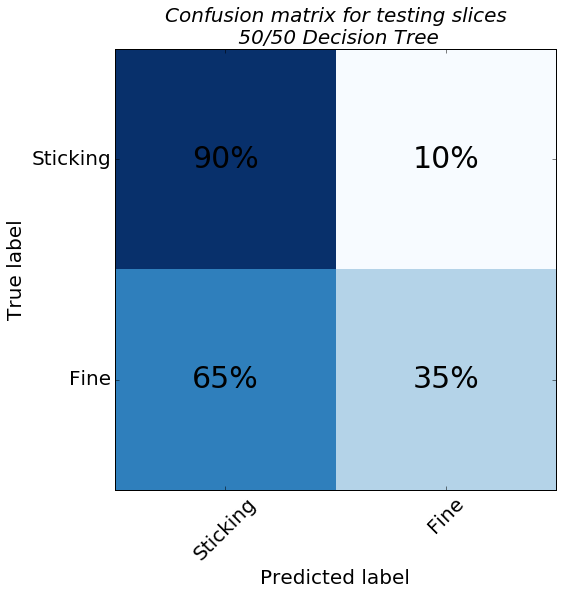

In [79]:
Y_predict = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' Decision Tree'
plot_confusion_matrix(cm_normalized, title=cm_title, filename='dt_slices_rand'+str(k))
print(cm)
print(cm_normalized)

# Show learning DB

## On coils

[[20  1]
 [12 11]]
[[ 0.95238095  0.04761905]
 [ 0.52173913  0.47826087]]


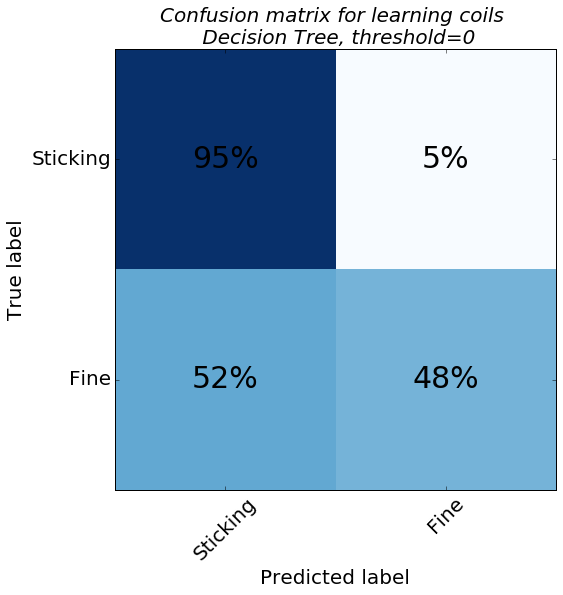

In [80]:
threshold = 0
suffix = 'threshold='+str(threshold)
result_DB, sumtrue, sumpredict = result_per_coil(learning_coils, clf)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                    cm_normalized, 
                    'Confusion matrix for learning coils \n Decision Tree, '+suffix,
                    filename='dt_db_coils_rand'+str(k)
                    )
print(cm)
print(cm_normalized)

## On 1s slices

[[1085   13]
 [1888 2079]]
[[ 0.98816029  0.01183971]
 [ 0.47592639  0.52407361]]


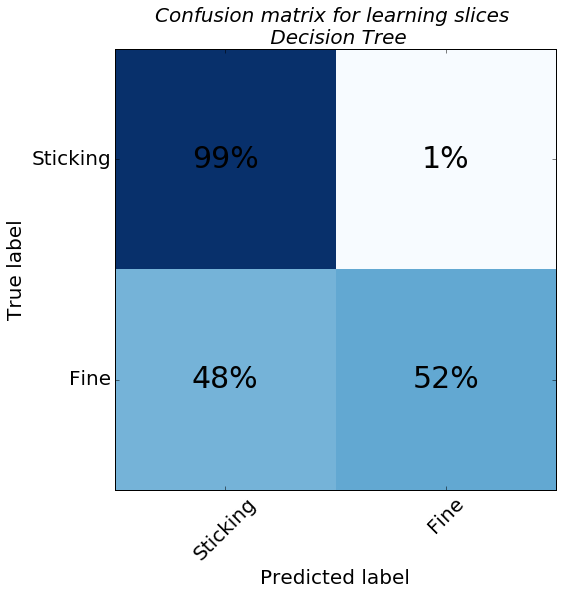

In [81]:
Y_predict = clf.predict(X_train)
cm = metrics.confusion_matrix(Y_train, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                        cm_normalized, 
                        'Confusion matrix for learning slices \n Decision Tree',
                        filename='dt_db_slices_rand'+str(k)
                        )
print(cm)
print(cm_normalized)

# Result per coil

In [82]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, clf)

[[16  1]
 [18  7]]
[[ 0.94117647  0.05882353]
 [ 0.72        0.28      ]]


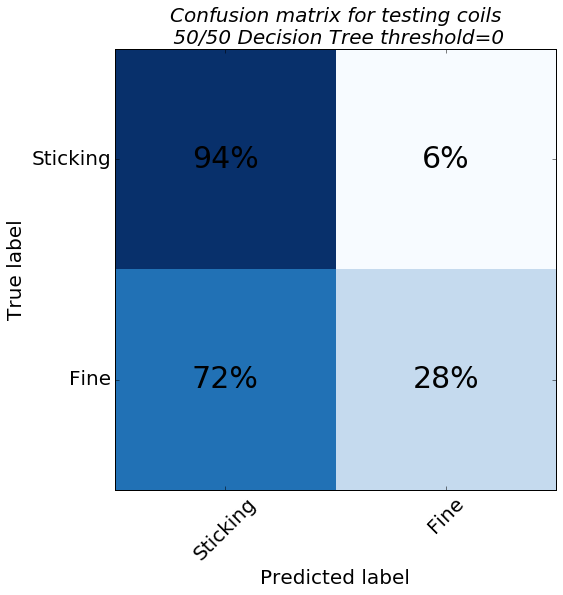

In [83]:
threshold = 0
suffix = ' Decision Tree threshold='+str(threshold)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+suffix
plot_confusion_matrix(cm_normalized, title=cm_title, filename='dt_coils_rand'+str(k))
print(cm)
print(cm_normalized)

## Sticking detection failure

### False fine (missed coils)

In [84]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
38           0     15
[38]
1
0.0
15.0


### False sticking (coils that should not have been inspected)

In [85]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
l2 = sorted(list(selection.index))
print(selection)
print(l2)
print(len(l2))
print(selection.prediction.mean())
np.abs(sumtrue-sumpredict).mean()

    prediction  truth
69          17      0
63          24      0
15          28      0
84          28      0
39          29      0
1           28      0
64          10      0
57          28      0
10           9      0
86          28      0
73          26      0
54          14      0
60          28      0
25          29      0
16          28      0
24          13      0
75          29      0
35          15      0
[1, 10, 15, 16, 24, 25, 35, 39, 54, 57, 60, 63, 64, 69, 73, 75, 84, 86]
18
22.8333333333


14.404761904761905

# Good data storage

In [73]:
learning_coils_1, testing_coils_1 = sorted(learning_coils), sorted(testing_coils)
print(learning_coils_1)

[3, 4, 9, 10, 11, 16, 17, 19, 22, 23, 24, 25, 28, 29, 30, 32, 36, 37, 39, 41, 43, 44, 45, 47, 50, 51, 52, 53, 54, 55, 61, 62, 66, 68, 70, 73, 74, 76, 77, 78, 80, 83, 85, 87]


## Data representation

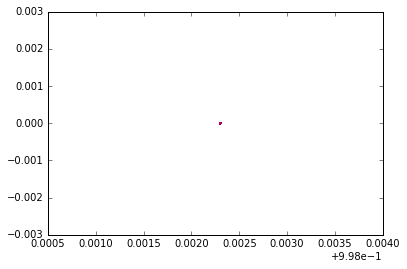

In [26]:
# this formatter will label the colorbar with the correct target names
#formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(df_total.Ximf2, df_total.Yimf2, df_total.sticking, color=["b", "r"])
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
#plt.xlabel(iris.feature_names[x_index])
#plt.ylabel(iris.feature_names[y_index])

# Old code results

[[ 9  3]
 [17 15]]
[[ 0.75     0.25   ]
 [ 0.53125  0.46875]]


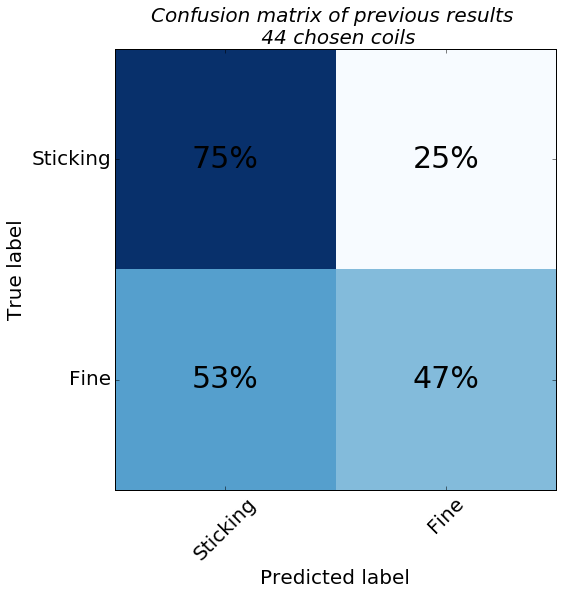

In [27]:
ytrue_old = np.ones(44).astype(bool)
ytrue_old[12:] = False
ytest_old = np.ones(44).astype(bool)
ytest_old[12:] = False
ytest_old[:3] = False
ytest_old[-17:] = True
sum(ytrue_old)
sum(ytest_old)
cm = metrics.confusion_matrix(ytrue_old, ytest_old, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                        cm_normalized, 
                        'Confusion matrix of previous results \n 44 chosen coils',
                        filename='cm_old'
                        )
print(cm)
print(cm_normalized)

# Plot sticking and prediction per coil

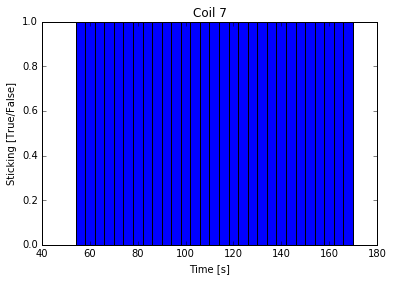

In [28]:
coil = l[0] #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = clf.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')

In [29]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
7            0     29
74           0     12
17           0      2
29           0     12
38           0     15
[7, 17, 29, 38, 74]
5
0.0
14.0


# K-Means

In [ ]:
from sklearn import cluster
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(X_train)
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X_train)

In [ ]:
axeX = 0
axeY = axeX + 3
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=k_means.labels_, color=['b', 'r'])

In [ ]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=Y_train.astype(int), color=['b', 'r'])

# K-means result per 4s slices

In [ ]:
Y_predict = k_means.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' K-Means'
plot_confusion_matrix(
    cm_normalized, 
    title=cm_title, 
    filename='kmeans_slices_rand'+str(k)
)
print(cm)
print(cm_normalized)

In [ ]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, estimator=k_means)

In [ ]:
threshold = 0
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+' K-Means'
plot_confusion_matrix(
    cm_normalized, 
    title=cm_title, 
    filename='kmeans_coils_rand'+str(k)
)
print(cm)
print(cm_normalized)

# K-means sticking detection failure

## False negative

In [ ]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
lkmeans = sorted(list(selection.index))
print(selection)
print(lkmeans)
print(len(lkmeans))
print(selection.prediction.mean())
print(selection.truth.mean())

## False positive

In [ ]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
lkmeans2 = sorted(list(selection.index))
print(selection)
print(lkmeans2)
print(len(lkmeans2))
print(selection.prediction.mean())

In [ ]:
coil = 6 #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = k_means.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')

In [ ]:
testing_coils==[12, 13, 16, 18, 19, 21, 30, 40, 41, 43, 46, 53, 55, 56, 57, 61, 66, 67, 68, 70, 77, 79, 85, 86, 87]

# Average CM for random selection

In [ ]:
ratio = 0.70
threshold = 0
nIter = 5
cm = np.zeros([nIter, 2, 2])
for randomSeletion in range(nIter):
    learning_coils, testing_coils = random_coils_selection(all_coils, ratio=ratio)
    df_total_train = concat_df(learning_coils, 'peak_1s_slice.h5')
    df_total_test = concat_df(testing_coils, 'peak_1s_slice.h5')
    X_train, Y_train = create_DB(df_total_train)
    X_test, Y_true = create_DB(df_total_test)
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        max_depth=9,
        class_weight={True: 4, False: 1}
    )
    clf = clf.fit(X_train, Y_train)
    result, sumtrue, sumpredict = result_per_coil(testing_coils, clf)
    ytrue = np.greater(sumtrue, 0)
    ypredict = np.greater(sumpredict, threshold)
    cm0 = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
    cm_normalized = cm0.astype('float') / cm0.sum(axis=1)[:, np.newaxis]
    cm[randomSeletion,:,:] = cm_normalized

In [ ]:
plot_confusion_matrix(
    cm.mean(0), 
    title='Average confusion matrix', 
    filename='Average confusion matrix'
)

In [ ]:
plot_confusion_matrix(
    cm.std(0), 
    title='Confusion matrix STD', 
    filename='STD confusion matrix'
)

In [ ]:
cm.min(0)

In [ ]:
cm.max(0)

# Cross validation

In [36]:
nSticking = 26
nFine = 33
nIter = 37
threshold = 2
cm = np.zeros([nIter, 2, 2])
for start in range(nIter):
    stop = start+nSticking
    startf = start
    stopf = startf+nFine
    l1 = sticking_coils[start: stop]+sticking_coils[0: stop-38]
    l2 = fine_coils[startf: stopf]+fine_coils[0: stopf-48]
    learning_coils = sorted(l1+l2)
    testing_coils = sorted(list(set(all_coils)-set(learning_coils)))
    df_total_train = concat_df(learning_coils, peakDB)
    df_total_test = concat_df(testing_coils, peakDB)
    X_train, Y_train = create_DB(df_total_train)
    X_test, Y_true = create_DB(df_total_test)
    clf = tree.DecisionTreeClassifier(
        criterion='gini', 
        max_depth=9,
        class_weight={True: 15, False: 1}
    )
    clf = clf.fit(X_train, Y_train)
    result, sumtrue, sumpredict = result_per_coil(testing_coils, clf)
    ytrue = np.greater(sumtrue, 0)
    ypredict = np.greater(sumpredict, threshold)
    cm0 = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
    cm_normalized = cm0.astype('float') / cm0.sum(axis=1)[:, np.newaxis]
    cm[start,:,:] = cm_normalized

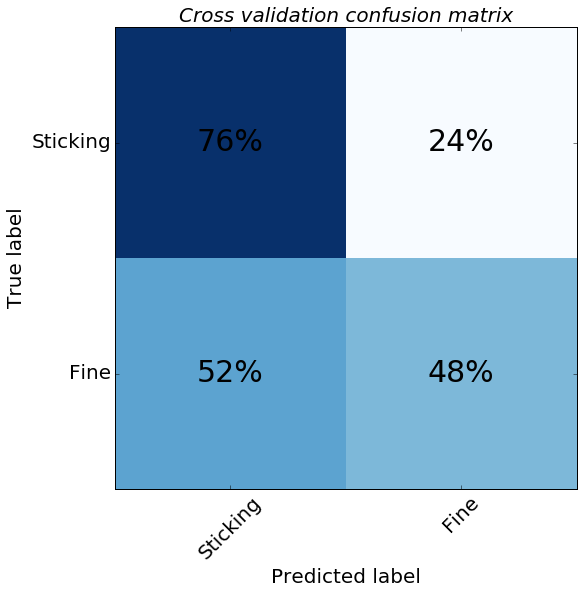

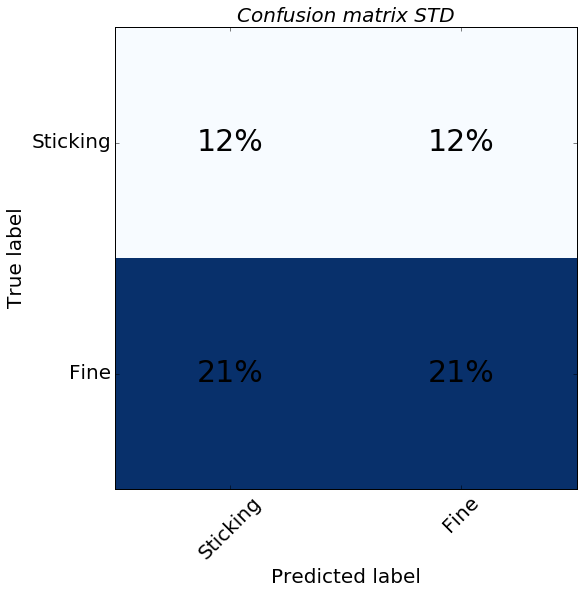

In [37]:
plot_confusion_matrix(
    cm.mean(0), 
    title='Cross validation confusion matrix', 
    filename='Cross validation confusion matrix'
)
plot_confusion_matrix(
    cm.std(0), 
    title='Confusion matrix STD', 
    filename='Confusion matrix STD'
)
plt.show()